# Single Stock Close-EWMA Crossover Strategy

- long when close > EWMA21 (i.e. close crosses above close)
- short when close < EWMA21 (i.e. close crosses below close)

## Import libraries

In [ ]:
pip install yfinance

In [2]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import skew
from scipy.stats import kurtosis
plt.style.use("seaborn-whitegrid")

## Load stock data

In [3]:
ticker = "AAPL"
aapl_df = yf.download(tickers=ticker, period="max", interval="1d", group_by="ticker", auto_adjust=True)
aapl_df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
1980-12-12,0.100600,0.101037,0.100600,0.100600,469033600
1980-12-15,0.095789,0.095789,0.095352,0.095352,175884800
1980-12-16,0.088790,0.088790,0.088353,0.088353,105728000
1980-12-17,0.090540,0.090977,0.090540,0.090540,86441600
1980-12-18,0.093165,0.093602,0.093165,0.093165,73449600
...,...,...,...,...,...
2021-08-05,146.760114,147.618828,145.951328,146.839996,46397700
2021-08-06,146.350006,147.110001,145.630005,146.139999,54067400
2021-08-09,146.199997,146.699997,145.520004,146.089996,48908700


## Get close prices

In [4]:
aapl_close = aapl_df.copy()
aapl_close = aapl_close.drop(columns=["Open", "High", "Low", "Volume"])
aapl_close = aapl_close.rename(columns={"Close":"AAPL"})
aapl_close

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.095352
1980-12-16,0.088353
1980-12-17,0.090540
1980-12-18,0.093165
...,...
2021-08-05,146.839996
2021-08-06,146.139999
2021-08-09,146.089996


## Visualise adjusted close prices

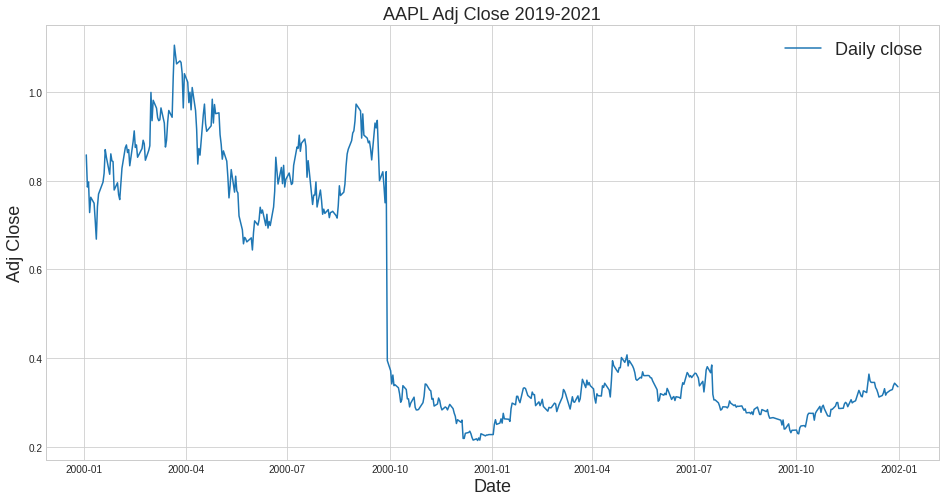

In [5]:
plt.figure(figsize=(16,8))
plt.plot(aapl_close.loc["2000-01-01":"2002-01-01", "AAPL"], label="Daily close")
plt.title("AAPL Adj Close 2019-2021", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Adj Close", fontsize=18)
plt.show()

## Exponentially Weighted Moving Average (EWMA)

In [6]:
def EWMA(df, period):
  return df.ewm(span=period, adjust=False).mean()

In [7]:
aapl_ewma = aapl_close.copy()
aapl_ewma.loc[:,"AAPL"] = EWMA(aapl_ewma, 21)
aapl_ewma

,AAPL
Date,
1980-12-12,0.100600
1980-12-15,0.100123
1980-12-16,0.099053
1980-12-17,0.098279
1980-12-18,0.097814
...,...
2021-08-05,144.631168
2021-08-06,144.768334
2021-08-09,144.888485


## Visualise SMA on top of adjusted close

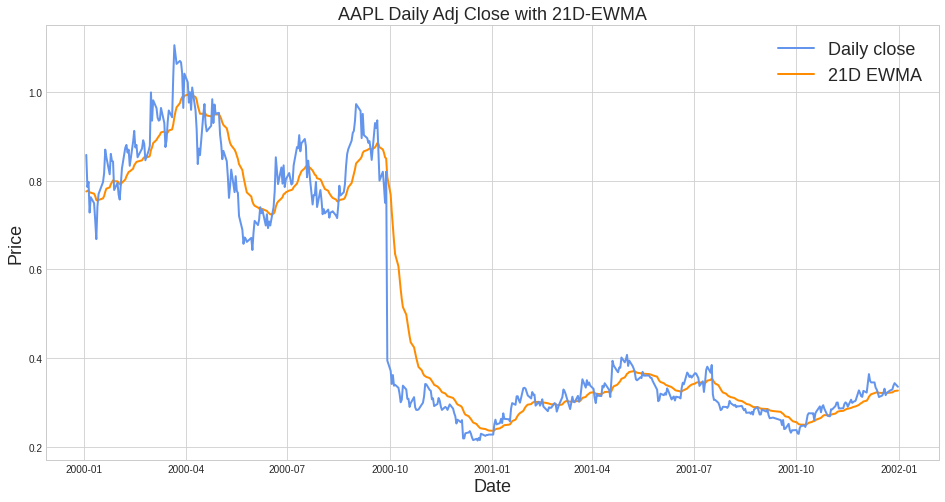

In [8]:
plt.figure(figsize=(16,8))
plt.plot(aapl_close.loc["2000-01-01":"2002-01-01","AAPL"], alpha=1.0, label="Daily close", linewidth=2, color="cornflowerblue", zorder=2)
plt.plot(aapl_ewma.loc["2000-01-01":"2002-01-01","AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="darkorange", zorder=1)
plt.title("AAPL Daily Adj Close with 21D-EWMA", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Compute long and short signals

- Long: close > EWMA21
- Short: close < EWMA21

In [9]:
def get_long_short(close, moving_avg):
  # create initial long/short signal dataframe with all zeros
  long_short = (close*0).fillna(0).astype(np.int)
  # create long signals when close > moving avg
  long_signals = (close > moving_avg).astype(np.int)
  # create short signals when close < moving avg
  short_signals = (close < moving_avg).astype(np.int)
  # combine both long and short signals
  long_short = long_short + long_signals - short_signals

  return long_short

In [10]:
# compute signals b/w 2020 and 2021 and cut ewma and close to that timeframe too
aapl_close = aapl_close.loc["2000-01-01":"2002-01-01", :]
aapl_ewma = aapl_ewma.loc["2000-01-01":"2002-01-01", :]
signal = get_long_short(aapl_close, aapl_ewma)
signal

,AAPL
Date,
2000-01-03,1
2000-01-04,1
2000-01-05,1
2000-01-06,-1
2000-01-07,-1
...,...
2001-12-24,1
2001-12-26,1
2001-12-27,1


## Filter signal

Filter out all consecutive-equal signals, so only long/short changes remain.

In [11]:
def filter_signal(signal):

  filtered_signal = signal.copy()
  for ticker in filtered_signal:
    filtered_signal.loc[filtered_signal[ticker].shift(1).eq(filtered_signal[ticker])] = 0
  
  return filtered_signal

In [12]:
filtered_signal = filter_signal(signal)
filtered_signal

,AAPL
Date,
2000-01-03,1
2000-01-04,0
2000-01-05,0
2000-01-06,-1
2000-01-07,0
...,...
2001-12-24,1
2001-12-26,0
2001-12-27,0


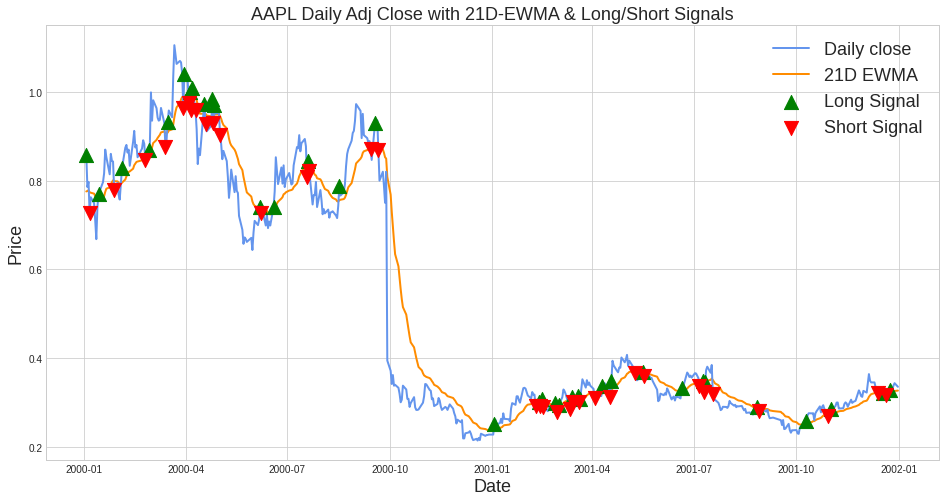

In [13]:
plt.figure(figsize=(16,8))
plt.plot(aapl_close.loc[:,"AAPL"], alpha=1.0, label="Daily close", linewidth=2, color="cornflowerblue", zorder=2)
plt.plot(aapl_ewma.loc[:,"AAPL"], alpha=1.0, label="21D EWMA", linewidth=2, color="darkorange", zorder=1)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==1, aapl_close.loc[:,"AAPL"], np.nan), alpha=1, label="Long Signal", marker="^", color="green", s=200, zorder=3)
plt.scatter(filtered_signal.index, np.where(filtered_signal.loc[:, "AAPL"]==-1, aapl_close.loc[:, "AAPL"], np.nan), alpha=1, label="Short Signal", marker="v", color="red", s=200, zorder=5)
plt.title("AAPL Daily Adj Close with 21D-EWMA & Long/Short Signals", fontsize=18)
plt.legend(fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Price", fontsize=18)
plt.show()

## Signal log returns

For each long/short signal get the price of the next (opposite) signal to compute the returns made in the period between signal changes.

In [14]:
def get_lookahead_returns(close, signal):

  entry_signals = signal.copy()
  entry_signals = entry_signals[entry_signals!=0].dropna(axis=0)

  entry_prices = close.copy()
  entry_prices = entry_prices[signal!=0].dropna(axis=0)

  exit_prices = entry_prices.shift(-1)
  price_returns = exit_prices/entry_prices - 1
  signal_returns = entry_signals * price_returns

  return pd.DataFrame(data={"Entry prices":entry_prices["AAPL"],
                            "Exit prices":exit_prices["AAPL"],
                            "Price returns":price_returns["AAPL"],
                            "Entry signals":entry_signals["AAPL"],
                            "Signal returns":signal_returns["AAPL"]}, index=entry_signals.index)

In [15]:
return_df = get_lookahead_returns(aapl_close, filtered_signal)
return_df.head(50)

,Entry prices,Exit prices,Price returns,Entry signals,Signal returns
Date,,,,,
2000-01-03,0.858137,0.728291,-0.151312,1.0,-0.151312
2000-01-06,0.728291,0.769976,0.057237,-1.0,-0.057237
2000-01-14,0.769976,0.779079,0.011823,1.0,0.011823
2000-01-28,0.779079,0.827952,0.062731,-1.0,-0.062731
2000-02-04,0.827952,0.846159,0.021991,1.0,0.021991
2000-02-25,0.846159,0.868199,0.026048,-1.0,-0.026048
2000-02-28,0.868199,0.875865,0.008829,1.0,0.008829
2000-03-14,0.875865,0.931924,0.064004,-1.0,-0.064004
2000-03-16,0.931924,0.964027,0.034448,1.0,0.034448


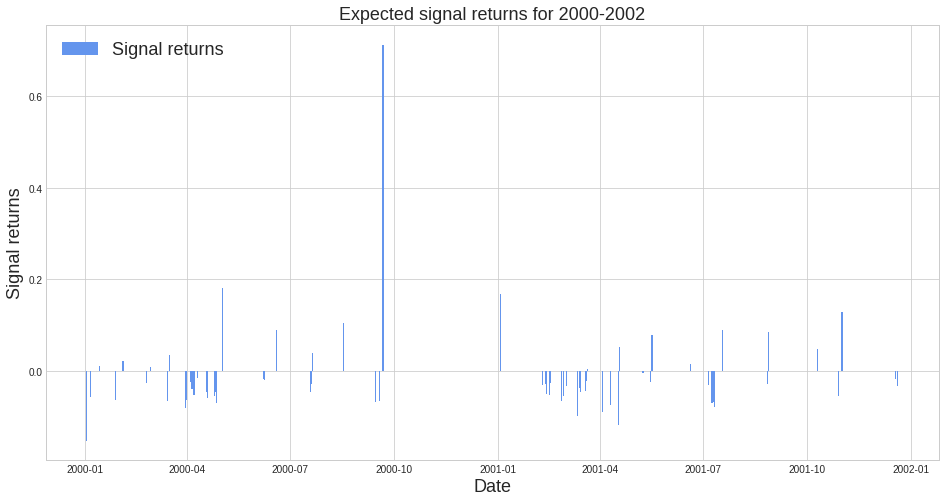

In [16]:
plt.figure(figsize=(16,8))
plt.bar(return_df.index, return_df.loc[:,"Signal returns"], alpha=1.0, label="Signal returns", width=1, color="cornflowerblue", zorder=1)
plt.legend(fontsize=18)
plt.title("Expected signal returns for 2000-2002", fontsize=18)
plt.xlabel("Date", fontsize=18)
plt.ylabel("Signal returns", fontsize=18)
plt.show()

## Show descriptive statistics of return distribution

In [17]:
stats_table = pd.DataFrame(data={"Stats":["Mean", "Median", "Max", "Min", "St. dev.","Skew", "Kurtosis"]})
stats_table.set_index("Stats", inplace=True)

stats_table["{}".format("Signal returns")] = [return_df.loc[:, "Signal returns"].mean(),
                                              return_df.loc[:, "Signal returns"].median(),
                                              return_df.loc[:, "Signal returns"].max(),
                                              return_df.loc[:, "Signal returns"].min(), 
                                              return_df.loc[:, "Signal returns"].std(), 
                                              skew(return_df.loc[:, "Signal returns"][0:-1]), 
                                              kurtosis(return_df.loc[:, "Signal returns"][0:-1], fisher=True)]
stats_table

,Signal returns
Stats,
Mean,-0.008649
Median,-0.031440
Max,0.711135
Min,-0.151312
St. dev.,0.108505
Skew,4.522310
Kurtosis,26.774677


## Cumulative returns

In [18]:
def cumulative_signal_returns(signal_returns):

  cumulative_returns = 1 # start with 100%
  for signal_return in signal_returns[:-1]:
    cumulative_returns = cumulative_returns * (1+signal_return)

  return cumulative_returns

In [19]:
signal_cum_ret = cumulative_signal_returns(return_df.loc[:, "Signal returns"])
signal_cum_ret

0.4042418439328812

In [20]:
# confirm function results
signal_cumulative_returns = (return_df.loc[:, "Signal returns"]+1).cumprod()
signal_cumulative_returns

Date
2000-01-03    0.848688
2000-01-06    0.800111
2000-01-14    0.809571
2000-01-28    0.758786
2000-02-04    0.775472
                ...   
2001-11-01    0.425285
2001-12-13    0.425082
2001-12-18    0.418203
2001-12-20    0.404242
2001-12-24         NaN
Name: Signal returns, Length: 69, dtype: float64